In [62]:
import json
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import os
import pandas as pd
import torch.nn.functional as F

In [25]:
# define the number of features
feature_num = 3

# DAILY
start_col = 1

# HOURLY
# start_col = 2

# define the number of time steps
time_step = 3

In [9]:
directory = 'Dataset/'

node_num = 0
dataset = []

# read csv files in Dataset folder
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        node_num += 1
        node = pd.read_csv(directory + filename).iloc[:, start_col: start_col + feature_num].values
        dataset.append(node)
        print(filename)

dataset = np.array(dataset)


cleaned_data_10.csv
cleaned_data_1.csv
cleaned_data_0.csv
cleaned_data_2.csv
cleaned_data_3.csv
cleaned_data_7.csv
cleaned_data_6.csv
cleaned_data_4.csv
cleaned_data_5.csv
cleaned_data_8.csv
cleaned_data_9.csv


In [10]:
dataset.shape

(11, 1095, 3)

In [11]:
dataset[0][0]

array([ 1.18206846,  2.27336876, 33.90688519])

In [26]:
dataset = dataset.reshape(node_num, feature_num, -1)

In [27]:
dataset.shape

(11, 3, 1095)

In [22]:
edges = [[], []]
for i in range(node_num):
    for j in range(node_num):
        edges[0].append(i)
        edges[1].append(j)

edges = np.array(edges)

# one weight for edges
edge_weight = np.ones(edges[0].shape)


In [32]:
# dataset: (time, feature, node)
# edge_weight: (edge)

# print shapes
print(dataset.shape)
print(edges.shape)
print(edge_weight.shape)

(11, 3, 1095)
(2, 121)
(121,)


In [283]:
# targets are in dataset after timestep
features_co = []
features_so2 = []
features_pm10 = []

targets_co = []
targets_so2 = []
targets_pm10 = []
for i in range(dataset.shape[2] - time_step):
    features_co.append(dataset[:, 0, i:i + time_step].reshape(node_num, time_step))
    features_so2.append(dataset[:, 1, i:i + time_step].reshape(node_num, time_step))
    features_pm10.append(dataset[:, 2, i:i + time_step].reshape(node_num, time_step))

    targets_co.append(dataset[:, 0, i + time_step].reshape(node_num, 1))
    targets_so2.append(dataset[:, 1, i + time_step].reshape(node_num, 1))
    targets_pm10.append(dataset[:, 2, i + time_step].reshape(node_num, 1))

features_co = np.array(features_co)
features_so2 = np.array(features_so2)
features_pm10 = np.array(features_pm10)

targets_co = np.array(targets_co)
targets_so2 = np.array(targets_so2)
targets_pm10 = np.array(targets_pm10)

In [284]:
print('feature shape:', features_co.shape)
print('target shape:', targets_co.shape)


feature shape: (1092, 11, 3)
target shape: (1092, 11, 1)


In [292]:
# import torch
# from torch import tensor

# # dataloader in torch geometic library
# from torch_geometric.data import Data

# temporal_co = Data(
#     src=tensor(features_co, dtype=torch.float),
#     dst=tensor(targets_co, dtype=torch.float),
#     edge_index=tensor(edges, dtype=torch.long),
# )


In [293]:
# from torch_geometric.loader import TemporalDataLoader
# batch_size = 2
# loader_co = TemporalDataLoader(temporal_co, batch_size=2, shuffle=True)

In [295]:
# loader_co

In [298]:
# for i in loader_co:
#     print(i)
#     break

In [299]:
# import torch
# import torch.nn.functional as F
# from torch_geometric_temporal.nn.recurrent import GConvGRU

# class RecurrentGCN(torch.nn.Module):

#     def __init__(self, node_features, num_classes):
#         super(RecurrentGCN, self).__init__()
#         self.recurrent_1 = GConvGRU(node_features, 32, 5)
#         self.recurrent_2 = GConvGRU(32, 16, 5)
#         self.linear = torch.nn.Linear(16, num_classes)

#     def forward(self, x, edge_index, edge_weight):
#         x = self.recurrent_1(x, edge_index, edge_weight)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.recurrent_2(x, edge_index, edge_weight)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.linear(x)
#         return F.log_softmax(x, dim=1)

# RecurrentGCN(3, 1)

In [217]:
# model = RecurrentGCN(3, 1)

In [296]:
# Base model
from torch_geometric_temporal import GConvGRU

# in_channel = feature_num 
# out_channel = 1

# k = 32

# # define model
# model = GConvGRU(in_channel, out_channel, k)
model = GConvGRU(in_channels=time_step , out_channels=1, K=5)


In [287]:
model

GConvGRU(
  (conv_x_z): ChebConv(3, 1, K=5, normalization=sym)
  (conv_h_z): ChebConv(1, 1, K=5, normalization=sym)
  (conv_x_r): ChebConv(3, 1, K=5, normalization=sym)
  (conv_h_r): ChebConv(1, 1, K=5, normalization=sym)
  (conv_x_h): ChebConv(3, 1, K=5, normalization=sym)
  (conv_h_h): ChebConv(1, 1, K=5, normalization=sym)
)

In [300]:
# # train
# from torch.optim import Adam

# optimizer = Adam(model.parameters(), lr=0.01)
# model.train()

# for epoch in range(5):
    
#     for batch in loader_co:
#         optimizer.zero_grad()
#         x, y, edge_index = batch.src, batch.dst, batch.edge_index
#         batch.to(torch.device('cpu'))
#         print(x.shape)
#         print(edge_index.shape)
#         # print(x.shape, edge_index)
#         out = model(x, edge_index)
#         loss = F.mse_loss(out, y)
#         loss.backward()
#         optimizer.step()
#     print(loss)

In [301]:
spatio = StaticGraphTemporalSignal(
    edges,
    edge_weight,
    features_co,
    targets_co
)

In [306]:
# batch iterator
from torch_geometric_temporal import StaticGraphTemporalSignalBatch

batch_size = 10
spatio_loader = StaticGraphTemporalSignalBatch(edges, edge_weight, features_co, targets_co, batch_size)


In [1]:
# save loader
import pickle

with open('loader.pkl', 'wb') as f:
    pickle.dump(spatio_loader, f)
    

NameError: name 'spatio_loader' is not defined

In [307]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(spatio_loader, train_ratio=0.8)

In [310]:
for i in train_dataset:
    print(i)
    break

DataBatch(x=[11, 3], edge_index=[2, 121], edge_attr=[121], y=[11, 1], batch=[10])


In [317]:
# train over train_datset batches
from torch.optim import Adam
import torch

optimizer = Adam(model.parameters(), lr=0.01)
model.train()

losses = []

for epoch in range(5):    
    for i, batch in enumerate(train_dataset):
        optimizer.zero_grad()
        batch.to(torch.device('cpu'))
        out = model(batch.x, batch.edge_index)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{5}], Step [{i+1}], Loss: {loss.item()}')
    print(loss)

Epoch [1/5], Step [100], Loss: 1.5012893676757812
Epoch [1/5], Step [200], Loss: 5.598830699920654
Epoch [1/5], Step [300], Loss: 7225.29248046875
Epoch [1/5], Step [400], Loss: 2.0279555320739746
Epoch [1/5], Step [500], Loss: 39.28966522216797
Epoch [1/5], Step [600], Loss: 3268.77734375
Epoch [1/5], Step [700], Loss: 3.632460832595825
Epoch [1/5], Step [800], Loss: 88.38957977294922
tensor(5091.9614, grad_fn=<MseLossBackward0>)
Epoch [2/5], Step [100], Loss: 1.5012893676757812
Epoch [2/5], Step [200], Loss: 5.598830699920654
Epoch [2/5], Step [300], Loss: 7225.29248046875
Epoch [2/5], Step [400], Loss: 2.0279555320739746
Epoch [2/5], Step [500], Loss: 39.28966522216797
Epoch [2/5], Step [600], Loss: 3268.77734375
Epoch [2/5], Step [700], Loss: 3.632460832595825
Epoch [2/5], Step [800], Loss: 88.38957977294922
tensor(5091.9614, grad_fn=<MseLossBackward0>)
Epoch [3/5], Step [100], Loss: 1.5012893676757812
Epoch [3/5], Step [200], Loss: 5.598830699920654
Epoch [3/5], Step [300], Loss: 

In [98]:
# save spatio 

import torch
torch.save(spatio, 'spatio.pt')

In [135]:
spatio

In [136]:
print("Dataset type:  ", spatio)
# print("Number of samples / sequences: ",  len(set(spatio)))
print(next(iter(spatio))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f82d00ab610>
Data(x=[11, 3, 3], edge_index=[2, 121], edge_attr=[121], y=[11, 1])


In [137]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(spatio, train_ratio=0.8)


In [181]:
# GPU support
DEVICE = torch.device('cpu') # cpu
shuffle=True
batch_size = 2

In [182]:
train_input = np.array(train_dataset.features)
print(train_input.shape)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
print(train_target.shape)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle, drop_last=True)

(873, 11, 3, 3)
(873, 11, 1)


In [183]:
train_loader

In [184]:
test_input = np.array(test_dataset.features)
print(test_input.shape)
test_target = np.array(test_dataset.targets) 
print(test_target.shape)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

(219, 11, 3, 3)
(219, 11, 1)


In [185]:
test_loader

In [186]:
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal import GConvGRU

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=3, periods=3, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(3, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(3, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(3, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [187]:
model = TemporalGNN(node_features=3, periods=3, batch_size=2)

In [250]:
# Base model
from torch_geometric_temporal import GConvGRU

in_channel = feature_num * time_step
out_channel = 1

k = 2

# define model
model = GConvGRU(in_channel, out_channel, k)

In [251]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [252]:
print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
conv_x_z.bias 	 torch.Size([1])
conv_x_z.lins.0.weight 	 torch.Size([1, 9])
conv_x_z.lins.1.weight 	 torch.Size([1, 9])
conv_h_z.bias 	 torch.Size([1])
conv_h_z.lins.0.weight 	 torch.Size([1, 1])
conv_h_z.lins.1.weight 	 torch.Size([1, 1])
conv_x_r.bias 	 torch.Size([1])
conv_x_r.lins.0.weight 	 torch.Size([1, 9])
conv_x_r.lins.1.weight 	 torch.Size([1, 9])
conv_h_r.bias 	 torch.Size([1])
conv_h_r.lins.0.weight 	 torch.Size([1, 1])
conv_h_r.lins.1.weight 	 torch.Size([1, 1])
conv_x_h.bias 	 torch.Size([1])
conv_x_h.lins.0.weight 	 torch.Size([1, 9])
conv_x_h.lins.1.weight 	 torch.Size([1, 9])
conv_h_h.bias 	 torch.Size([1])
conv_h_h.lins.0.weight 	 torch.Size([1, 1])
conv_h_h.lins.1.weight 	 torch.Size([1, 1])
Net's total params: 66
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': False, 'p

In [209]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break

In [253]:
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        # print(encoder_inputs.shape)
        # print(static_edge_index.shape)
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        # print(y_hat.shape)
        # print(labels.shape)
        loss = loss_fn(y_hat, labels.reshape(batch_size, node_num, 1)) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 1 == 0 :
            print(sum(loss_list)/len(loss_list))

    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

RuntimeError: index 3 is out of bounds for dimension 0 with size 3

In [195]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels.reshape(batch_size, node_num, 1))
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 2473.5411


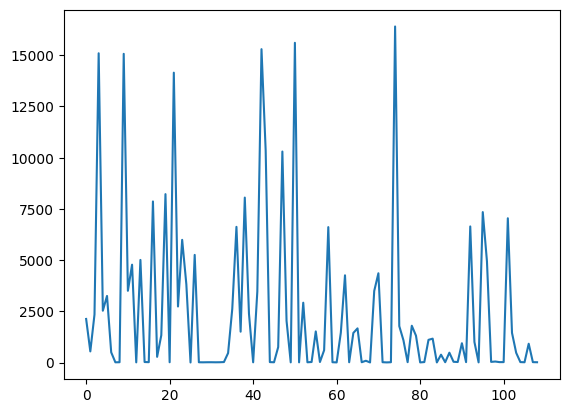

In [205]:
plt.plot(total_loss)

In [196]:
sensor = 9
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([np.array(label[sensor]) for label in labels])
print("Data points:,", preds.shape)
print("Labels shape:", labs.shape)

Data points:, (2,)
Labels shape: (2, 1)


<AxesSubplot:>

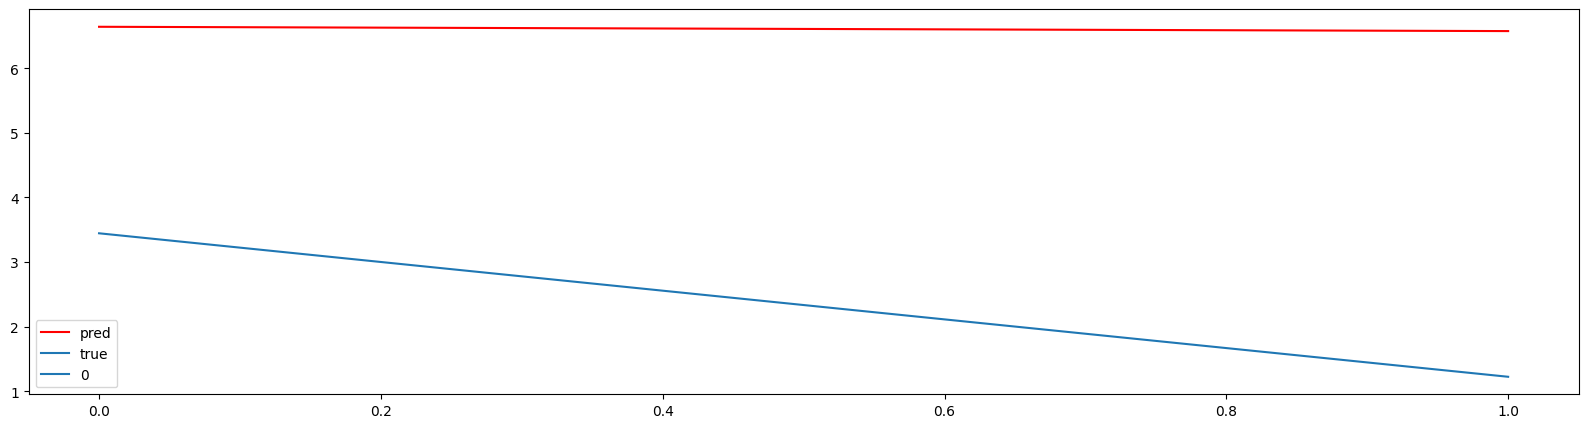

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred", color='red')
sns.lineplot(data=labs, label="true")